In [32]:
#-*- coding:utf-8 -*-

import os
import sys
import time
import datetime
import pickle
import random

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2

import torch

from tqdm import tqdm
from scipy.interpolate import interp1d

In [33]:
SEED = 12345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

## Load and Preprocess the seneor label data

In [34]:
file_list = os.listdir('dataset_twosources_raw')
file_list.sort()

In [35]:
sample_info_list = []

for file_name in file_list:
    idx = file_name.split('_')[0]
    element_1 = file_name.split('_')[1]
    concentrate_1 = file_name.split('_')[2]
    element_2 = file_name.split('_')[3]
    concentrate_2 = file_name.split('_')[4]
    sample_info_list.append([idx, element_1, concentrate_1, element_2, concentrate_2])
sample_info_array = np.array(sample_info_list)

In [36]:
sample_info_df = pd.DataFrame(sample_info_array, columns=['idx', 'element_1', 'concentrate_1', 'element_2', 'concentrate_2'])
sample_info_df.head()

,idx,element_1,concentrate_1,element_2,concentrate_2
0,000,Et,H,CO,n
1,001,Et,L,Me,H
2,002,Et,H,CO,H
3,003,Et,H,Me,n
4,004,Et,L,CO,H


In [37]:
label_list = []
for idx in range(len(sample_info_df)):
    sample = sample_info_df.iloc[idx]
    concentrate_dict = {'Et': None, 'CO': None, 'Me': None}
    concentrate_dict[sample['element_1']] = sample['concentrate_1']
    concentrate_dict[sample['element_2']] = sample['concentrate_2']
    values = list(concentrate_dict.values())
    label_list.append([sample['idx']]+values+[values])
label_list = pd.DataFrame(label_list, columns = ['idx', 'Et', 'CO', 'Me', 'Combination'])
label_list.head()

,idx,Et,CO,Me,Combination
0,000,H,n,None,"[H, n, None]"
1,001,L,None,H,"[L, None, H]"
2,002,H,H,None,"[H, H, None]"
3,003,H,None,n,"[H, None, n]"
4,004,L,H,None,"[L, H, None]"


In [38]:
Combination_list = [tuple(x) for x in label_list['Combination']]
Unique_Combination_list = list(set(Combination_list))
len(Unique_Combination_list) # 30 combinations out of 180 samples 

30

In [39]:
label_list = []
for idx in range(len(sample_info_df)):
    sample = sample_info_df.iloc[idx]
    concentrate_dict = {'Et': 0, 'CO': 0, 'Me': 0}
    if sample['concentrate_1'] != 'n' and sample['concentrate_1'] != None:
        concentrate_dict[sample['element_1']] = 1
    if sample['concentrate_2'] != 'n' and sample['concentrate_2'] != None:
        concentrate_dict[sample['element_2']] = 1
    values = list(concentrate_dict.values())
    label_list.append([sample['idx']]+values+[values])
label_list = pd.DataFrame(label_list, columns = ['idx', 'Et', 'CO', 'Me', 'Combination'])
label_list.head()

,idx,Et,CO,Me,Combination
0,000,1,0,0,"[1, 0, 0]"
1,001,1,0,1,"[1, 0, 1]"
2,002,1,1,0,"[1, 1, 0]"
3,003,1,0,0,"[1, 0, 0]"
4,004,1,1,0,"[1, 1, 0]"


In [40]:
Combination_list = [tuple(x) for x in label_list['Combination']]
Unique_Combination_list = list(set(Combination_list))
len(Unique_Combination_list) # 30 combinations out of 180 samples 

5

In [41]:
data_df = label_list
data_df.sort_index(inplace=True)

In [42]:
combination_to_label_dict = dict(zip(Unique_Combination_list, range(len(Unique_Combination_list))))
data_df['Label'] = data_df['Combination'].apply(lambda s: combination_to_label_dict[tuple(s)])
data_df

,idx,Et,CO,Me,Combination,Label
0,000,1,0,0,"[1, 0, 0]",1
1,001,1,0,1,"[1, 0, 1]",3
2,002,1,1,0,"[1, 1, 0]",0
3,003,1,0,0,"[1, 0, 0]",1
4,004,1,1,0,"[1, 1, 0]",0
...,...,...,...,...,...,...
175,175,1,0,0,"[1, 0, 0]",1
176,176,1,0,0,"[1, 0, 0]",1
177,177,0,0,1,"[0, 0, 1]",2
178,178,0,1,0,"[0, 1, 0]",4


In [43]:
labels, counts = np.unique(data_df['Combination'], return_counts=True)
np.array([labels, counts]).T

array([[list([0, 0, 1]), 18],
       [list([0, 1, 0]), 18],
       [list([1, 0, 0]), 36],
       [list([1, 0, 1]), 54],
       [list([1, 1, 0]), 54]], dtype=object)

In [44]:
labels, counts = np.unique(data_df['Label'], return_counts=True)
np.array([labels, counts]).T

array([[ 0, 54],
       [ 1, 36],
       [ 2, 18],
       [ 3, 54],
       [ 4, 18]])

In [45]:
#add data split, save it
train_df = []
test_df = []
splits = []

for idx in range(len(Unique_Combination_list)):
    index = data_df.loc[data_df['Label']==idx].index.to_list()
    train_index = np.random.choice(np.array(index), round(len(index)*0.7), replace=False)
    test_index = [ii for ii in index if ii not in train_index]
    print(len(index), len(train_index), len(test_index))
    
    train_df.append(data_df.loc[train_index])
    test_df.append(data_df.loc[test_index])
    splits.append([idx, train_index, test_index])
    
train_df = pd.concat(train_df)
test_df = pd.concat(test_df)

54 38 16
36 25 11
18 13 5
54 38 16
18 13 5


In [46]:
print(train_df.shape)
train_df.head()

(127, 6)


,idx,Et,CO,Me,Combination,Label
94,094,1,1,0,"[1, 1, 0]",0
136,136,1,1,0,"[1, 1, 0]",0
134,134,1,1,0,"[1, 1, 0]",0
102,102,1,1,0,"[1, 1, 0]",0
22,022,1,1,0,"[1, 1, 0]",0


In [47]:
print(test_df.shape)
test_df.head()

(53, 6)


,idx,Et,CO,Me,Combination,Label
4,004,1,1,0,"[1, 1, 0]",0
34,034,1,1,0,"[1, 1, 0]",0
38,038,1,1,0,"[1, 1, 0]",0
52,052,1,1,0,"[1, 1, 0]",0
58,058,1,1,0,"[1, 1, 0]",0


In [48]:
with open ('label_list.pkl', 'wb') as f:
    pickle.dump(data_df, f)

with open ('splits/label_train_list.pkl', 'wb') as f:
    pickle.dump(train_df, f)

with open ('splits/label_test_list.pkl', 'wb') as f:
    pickle.dump(test_df, f)

In [49]:
with open ('train_index', 'wb') as f:
    pickle.dump(list(train_df.index), f)

with open ('test_index', 'wb') as f:
    pickle.dump(list(test_df.index), f)

## Load and Preprocess the seneor response data

In [50]:
file_list = os.listdir('dataset_twosources_raw')
file_list.sort()

In [51]:
sensor_data_list = []
for file_name in file_list:
    sensor_data_list.append(pd.read_csv(os.path.join('dataset_twosources_downsampled', file_name), header=None))

In [53]:
sensor_data_np = np.asarray(sensor_data_list, dtype=object)

In [54]:
sensor_data_train_np = sensor_data_np[list(train_df.index)]
sensor_data_test_np = sensor_data_np[list(test_df.index)]

In [55]:
with open ('data_list.pkl', 'wb') as f:
    pickle.dump(sensor_data_np, f)
    
with open ('splits/data_train_list.pkl', 'wb') as f:
    pickle.dump(sensor_data_train_np, f)
    
with open ('splits/data_test_list.pkl', 'wb') as f:
    pickle.dump(sensor_data_test_np, f)

## Using train data, estimate the distribution for each sensor

In [75]:
#sensor_data_all = np.concatenate(sensor_data_list)
sensor_data_all = np.concatenate(sensor_data_train_np)
sensor_data_all = sensor_data_all[:,3:]

In [76]:
sensor_data_all.shape

(377190, 8)

In [77]:
sensor_response_distribution_list = []
for sensor_data in sensor_data_all.T:
    sensor_response_distribution_list.append(sensor_data)

In [78]:
true_max = np.max(sensor_data_all, axis=0)
true_max

array([518.0, 426.0, 795.0, 970.0, 962.0, 1184.0, 1081.0, 1172.0],
      dtype=object)

In [79]:
RESPONSE_MAX = np.max(true_max)
RESPONSE_MAX

1184.0

In [80]:
with open ('response_max', 'wb') as f:
    pickle.dump(RESPONSE_MAX, f)

In [81]:
IMAGE_X = 640
IMAGE_Y = 480

In [82]:
data = sensor_data_np[0]

In [83]:
data.shape

(2970, 11)

In [84]:
def convert_datetime(date_time_str):
    return datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S').timestamp()

In [101]:
    x = range(len(data[:,0]))
    y = data[:,4]

In [102]:
f0 = interp1d(x, y)

In [103]:
f1 = interp1d(x, y, kind='cubic')
f2 = interp1d(x, y, kind='quadratic')

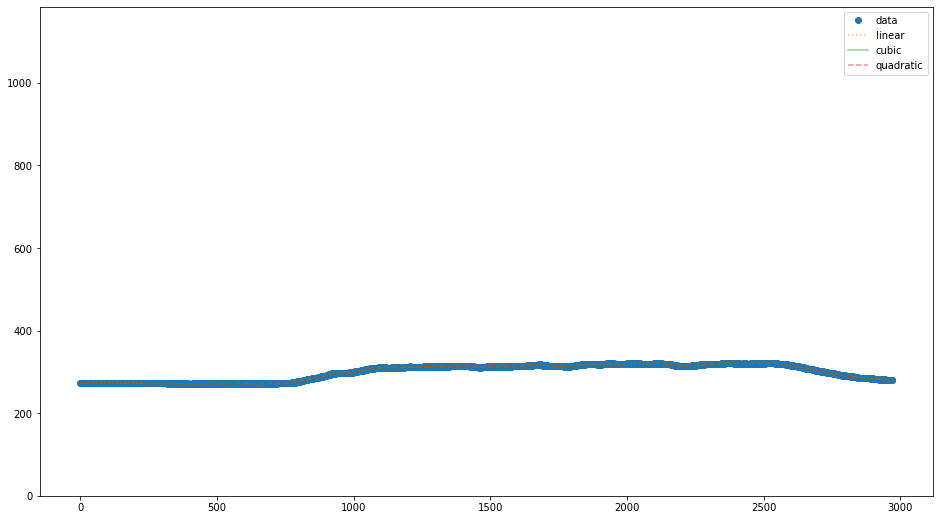

In [104]:
x_new = np.linspace(0, max(x), 100, endpoint=True)

plt.figure(figsize=(16,9))
plt.plot(x,y, 'o', label='data')
plt.plot(x_new, f0(x_new), ':', alpha = 0.5, label = 'linear')
plt.plot(x_new, f1(x_new), '-', alpha = 0.5,  label = 'cubic')
plt.plot(x_new, f2(x_new), '--', alpha = 0.5,  label = 'quadratic')
plt.ylim(0, RESPONSE_MAX)
plt.legend()
plt.show()

In [105]:
x_new = np.linspace(0, max(x), 10000, endpoint=True)
f_interpolation = interp1d(x, y, kind='quadratic')
y_new = f_interpolation(x_new)

In [106]:
#x_edge = range(0, int(max(x_new))+1, 1)
#y_edge = range(0, round(RESPONSE_MAX)+1, 1)

x_edge = np.linspace(0, int(max(x_new))+1, 640+1, endpoint=True)
y_edge = np.linspace(0, round(RESPONSE_MAX)+1, 480+1, endpoint=True)

In [107]:
H, xedges, yedges = np.histogram2d(x_new, y_new, bins=(x_edge, y_edge))
H = H.T

In [108]:
H_filp = np.flipud(H)

In [109]:
H_filp.shape

(480, 640)

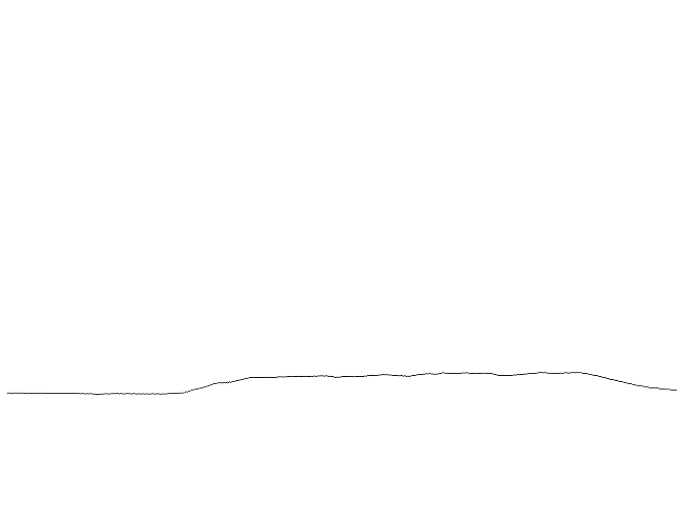

In [110]:
plt.figure(figsize=(12,18))
plt.imshow(H_filp, cmap='Greys')
plt.axis('off')
plt.show()

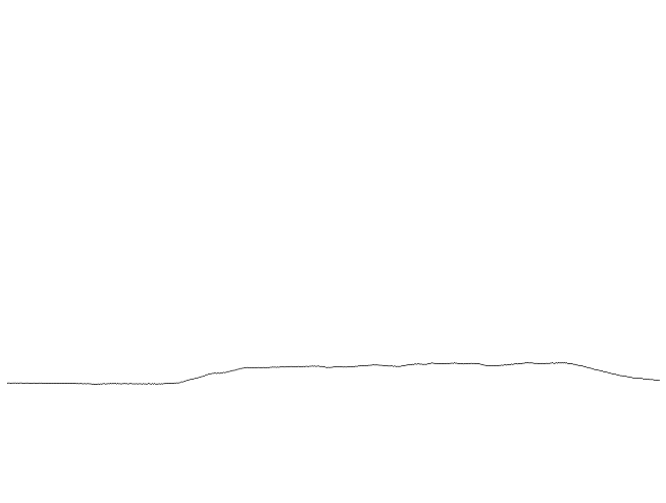

In [111]:
import cv2

res = cv2.resize(H_filp, dsize=(640, 480), interpolation=cv2.INTER_AREA)

plt.figure(figsize=(16,9))
plt.axis('off')
plt.margins(0)
plt.imshow(res, cmap='Greys')

In [119]:
def sample_to_tensor(data):
    x = range(len(data[:,0]))
    
    res_list = []
    for i in range(3,data.shape[1]):
        y = data[:,i]
        x_new = np.linspace(0, max(x), 10000, endpoint=True)
        f_interpolation = interp1d(x, y, kind='quadratic')
        y_new = f_interpolation(x_new)

        #2d hist
        x_edge = np.linspace(0, int(max(x_new))+1, 640+1, endpoint=True)
        y_edge = np.linspace(0, round(RESPONSE_MAX)+1, 480+1, endpoint=True)
        H, xedges, yedges = np.histogram2d(x_new, y_new, bins=(x_edge, y_edge))
        H = H.T
        H_filp = np.flipud(H)

        res = cv2.resize(H_filp, dsize=(640, 480), interpolation=cv2.INTER_AREA)
        res_list.append(res)
    return torch.tensor(res_list)

In [120]:
data_tensor = sample_to_tensor(data)

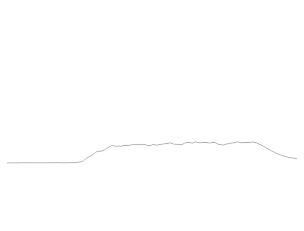

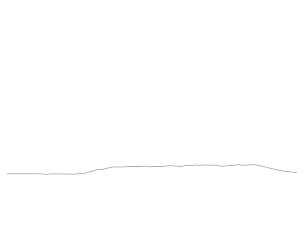

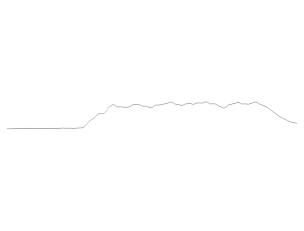

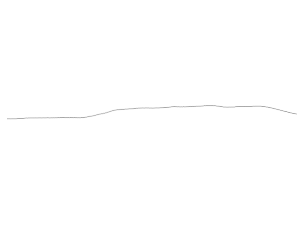

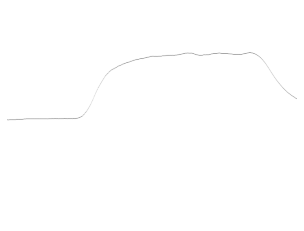

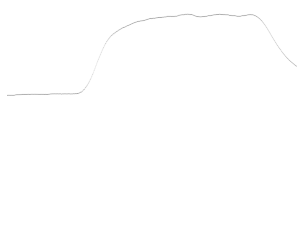

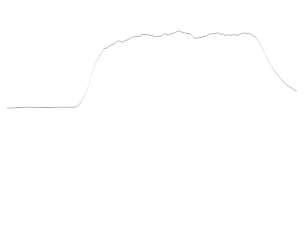

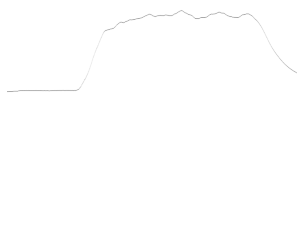

In [121]:
for res in data_tensor:
    plt.axis('off')
    plt.margins(0)
    plt.imshow(res, cmap='Greys')
    plt.show()

In [ ]:
preprocess_results = []
for idx in tqdm(range(len(sensor_data_np))):
    sample_info = df_list.iloc[idx]
    data = sensor_data_np[idx]
    data_tensor = sample_to_tensor(data)
    preprocess_results.append([sample_info, data_tensor])

In [ ]:
with open ('sample_info_tensor_list.pkl', 'wb') as f:
    pickle.dump(preprocess_results, f)